In [1]:
import os
from prometheus_client import Gauge
from prometheus_api_client import PrometheusConnect, MetricSnapshotDataFrame
from prometheus_api_client.utils import parse_datetime
from dotenv import load_dotenv
import pandas as pd
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5

load_dotenv()

# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, SGDRegressor

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

import numpy as np

from joblib import dump, load
import warnings
# warnings.filterwarnings('ignore')

In [2]:
prom = PrometheusConnect(url=os.getenv('PROMETHEUS_URL'), disable_ssl=True)

start_time = parse_datetime("2022-05-07 15:52:32")
#end_time = parse_datetime("now")
end_time = parse_datetime("2022-05-07 16:19:36")
plot_time = str(parse_datetime("30m")).split('.')[0]
#label_config = {'host': 'localhost'}
#requests_seconds = MetricSnapshotDataFrame(prom.get_metric_range_data('nginx_vts_server_request_seconds', start_time=start_time, end_time=end_time, label_config=label_config, chunk_size=timedelta(seconds=15)))
#requests_seconds = MetricSnapshotDataFrame(prom.get_metric_range_data('btalert_requests_per_second', start_time=start_time, end_time=end_time, chunk_size=timedelta(seconds=15)))
requests_seconds = MetricSnapshotDataFrame(prom.get_metric_range_data('btalert_failed_requests_percent', start_time=start_time, end_time=end_time, chunk_size=timedelta(seconds=15)))

requests_seconds.head()

c:\users\denis\desktop\api6\btalert-ai\venv\lib\site-packages\dateparser\date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


,__name__,instance,job,timestamp,value
0,btalert_failed_requests_percent,btalert-ai:5050,btalert-ai-exporter,1.651950e+09,46.55584217063151
1,btalert_failed_requests_percent,btalert-ai:5050,btalert-ai-exporter,1.651950e+09,49.36363636363636
2,btalert_failed_requests_percent,btalert-ai:5050,btalert-ai-exporter,1.651950e+09,50.73010827456045
3,btalert_failed_requests_percent,btalert-ai:5050,btalert-ai-exporter,1.651950e+09,50.75638506876228
4,btalert_failed_requests_percent,btalert-ai:5050,btalert-ai-exporter,1.651950e+09,48.883350905779736


In [3]:


req_dataframe = requests_seconds[['timestamp', 'value']].copy()
req_dataframe['timestamp'] = [datetime.fromtimestamp(timestamp) for timestamp in req_dataframe['timestamp']]
req_dataframe['value'] = [float(value) for value in req_dataframe['value']]

req_dataframe['timestamp'] = req_dataframe['timestamp'].astype('datetime64[s]')
req_dataframe = req_dataframe.set_index(req_dataframe['timestamp'])
#req_dataframe = req_dataframe.drop(columns='timestamp')

print(f'Number of rows with missing values: {req_dataframe.isnull().any(axis=1).mean()}')
req_dataframe = req_dataframe.asfreq(freq='15S', method='bfill')
print(f'Number of rows with missing values: {req_dataframe.isnull().any(axis=1).mean()}')


Number of rows with missing values: 0.0
Number of rows with missing values: 0.0


20 lags
Train dates : 2022-05-07 15:52:34 --- 2022-05-07 16:14:34  (n=89)
Test dates  : 2022-05-07 16:14:49 --- 2022-05-07 16:19:34  (n=20)


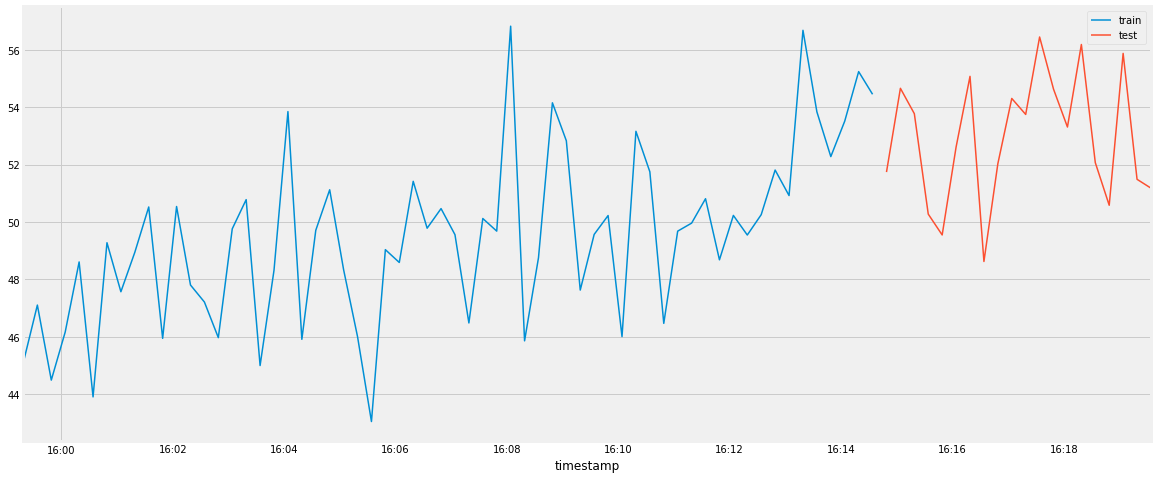

In [4]:
def minutes_to_step(min: int):
    lags = int((min * 60) / 15)
    print(lags, 'lags')
    return lags

steps = minutes_to_step(5) # 120 * 15seg = 30min
#steps = 8 # 8 * 15seg = 2min
data_train = req_dataframe[:-steps]
data_test  = req_dataframe[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax=plt.subplots(figsize=(18, 8))
data_train[plot_time:]['value'].plot(ax=ax, label='train')
data_test[plot_time:]['value'].plot(ax=ax, label='test')
ax.legend()

40 lags


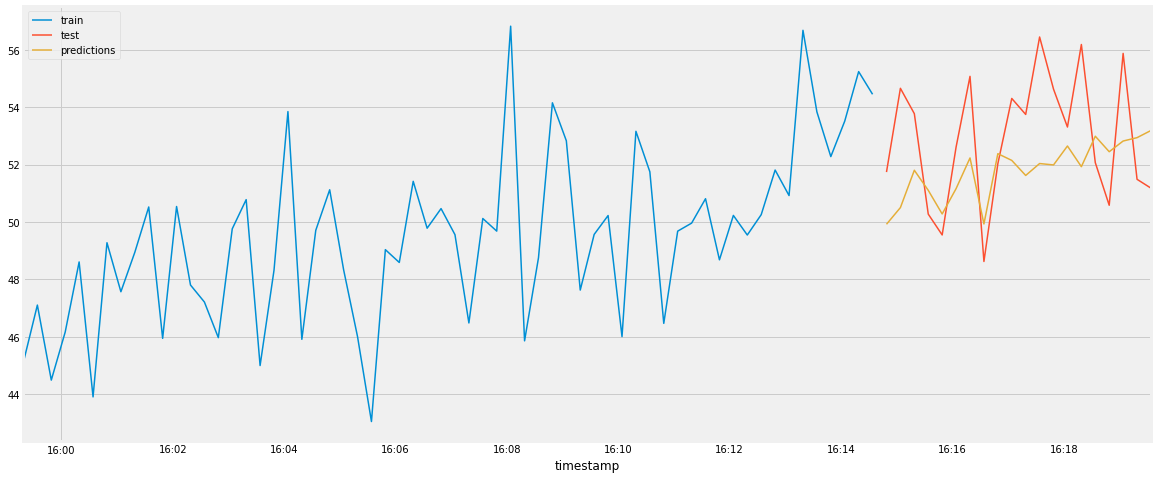

In [5]:
minutes = 10
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = minutes_to_step(minutes) # lags * 15seg = x min, para usar como predição
                )

forecaster.fit(y=data_train['value'])

#steps_prediction = 12 # 8 * 15seg = 2min
#steps_prediction = 120 # 120 * 15seg = 30min
steps_prediction = steps
predictions = forecaster.predict(steps=steps_prediction)

fig, ax = plt.subplots(figsize=(18, 8))
data_train[plot_time:]['value'].plot(ax=ax, label='train')
data_test[plot_time:]['value'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend()

In [6]:
error_mse = mean_squared_error(
                y_true = data_test['value'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 5.579280331327302


40 lags


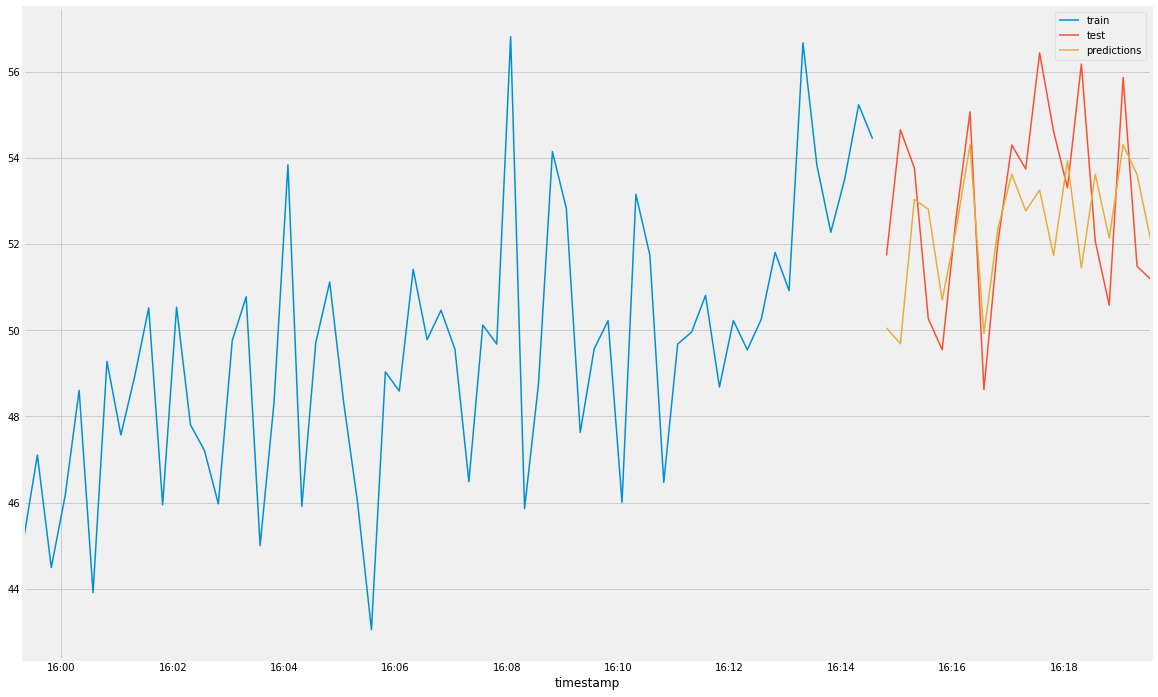

In [7]:
# Create and train forecaster with the best hyperparameters
# ==============================================================================

regressor = RandomForestRegressor(
                max_depth    = 40,
                n_estimators = 3,
                random_state = 123,
                #criterion    = 'absolute_error',
                #max_features = 'sqrt'
            )

forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = minutes_to_step(minutes)
             )

forecaster.fit(y=data_train['value'])

# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps_prediction)

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(18, 12))
data_train[plot_time:]['value'].plot(ax=ax, label='train')
data_test[plot_time:]['value'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [8]:
error_mse = mean_squared_error(
                y_true = data_test['value'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 4.681216246074975


In [9]:
for i in range(len(data_test)):
    real = data_test.iloc[i]['value']
    data = data_test.iloc[i]['timestamp']
    previsto = predictions[i]
    print(f'Data: {data} | Real: {real} | Previsto: {previsto} | diff: {previsto - real}')

Data: 2022-05-07 16:14:49 | Real: 51.73913043478261 | Previsto: 50.05586160875665 | diff: -1.6832688260259587
Data: 2022-05-07 16:15:04 | Real: 54.65693726563292 | Previsto: 49.689409767212034 | diff: -4.9675274984208855
Data: 2022-05-07 16:15:19 | Real: 53.77368476765111 | Previsto: 53.03609738363181 | diff: -0.7375873840192995
Data: 2022-05-07 16:15:34 | Real: 50.27526747688792 | Previsto: 52.814606622667874 | diff: 2.5393391457799552
Data: 2022-05-07 16:15:49 | Real: 49.54908261635742 | Previsto: 50.70293913629839 | diff: 1.1538565199409732
Data: 2022-05-07 16:16:04 | Real: 52.61070011793717 | Previsto: 52.34712951757484 | diff: -0.2635706003623284
Data: 2022-05-07 16:16:19 | Real: 55.073557148245946 | Previsto: 54.31030646865788 | diff: -0.7632506795880687
Data: 2022-05-07 16:16:34 | Real: 48.62470382198414 | Previsto: 49.92571842936101 | diff: 1.301014607376871
Data: 2022-05-07 16:16:49 | Real: 52.03051643192488 | Previsto: 52.35736435195761 | diff: 0.32684792003272634
Data: 2022-

In [22]:
resultado = pd.DataFrame()

In [26]:
resultado['timestamp'] = data_test['timestamp']
resultado['req_failed_%_real'] = data_test['value']
resultado['req_failed_%_predicted'] = predictions
resultado['abs_difference_error'] = abs(resultado['req_failed_%_predicted'] - resultado['req_failed_%_real'])

In [27]:
resultado.head(len(resultado))

,timestamp,req_failed_%_real,req_failed_%_predicted,abs_difference_error
timestamp,,,,
2022-05-07 16:14:49,2022-05-07 16:14:49,51.739130,50.055862,1.683269
2022-05-07 16:15:04,2022-05-07 16:15:04,54.656937,49.689410,4.967527
2022-05-07 16:15:19,2022-05-07 16:15:19,53.773685,53.036097,0.737587
2022-05-07 16:15:34,2022-05-07 16:15:34,50.275267,52.814607,2.539339
2022-05-07 16:15:49,2022-05-07 16:15:49,49.549083,50.702939,1.153857
2022-05-07 16:16:04,2022-05-07 16:16:04,52.610700,52.347130,0.263571
2022-05-07 16:16:19,2022-05-07 16:16:19,55.073557,54.310306,0.763251
2022-05-07 16:16:34,2022-05-07 16:16:34,48.624704,49.925718,1.301015
2022-05-07 16:16:49,2022-05-07 16:16:49,52.030516,52.357364,0.326848


In [28]:
resultado.describe()

,req_failed_%_real,req_failed_%_predicted,abs_difference_error
count,20.000000,20.000000,20.000000
mean,52.906945,52.389033,1.725915
std,2.250085,1.432137,1.338669
min,48.624704,49.689410,0.263571
25%,51.410069,51.667727,0.756835
50%,52.959474,52.566087,1.428451
75%,54.635032,53.622176,2.235635
max,56.444632,54.310306,4.967527
